## CNN Weather Condition Classification


We use a convolutional neural network (CNN) implemented in PyTorch to classify weather conditions into four categories: sunrise, shine, rainy, and cloudy. After a preliminary data exploration, we trained our model, achieving an overall accuracy of 88%. The model excelled in classifying sunrise, shine, and cloudy, with accuracies exceeding 90% for each category. The most common misclassifications occurred when rainy images were incorrectly classified as cloudy, which is an expected outcome given their visual similarities. 
At the end of the notebook, you will find several examples of images along with their actual and predicted labels.

[Dataset Source](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset/data)

In [110]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torch.optim as optim
from torch.utils.data import Subset

import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# To ensure reproducibility of the results
torch.manual_seed(7)
np.random.seed(0)

## Light EDA

In [ ]:
current_dir = current_dir = Path.cwd()  
datasetPath = current_dir.parent / "Multi-class-Weather-Dataset" 
# Load the original dataset
raw_dataset = torchvision.datasets.ImageFolder(root=datasetPath,transform=None)

# Inspect class-to-index mapping
print(f"Class-to-Index Mapping: {raw_dataset.class_to_idx}")

## Proportion of classes 
from collections import Counter

classLabels = [label for _, label in raw_dataset]
classCount = Counter(classLabels)
print('Class distribution:', classCount)

## Dimension Inspection
dimensions = [Image.open(path).size for path, _ in raw_dataset.imgs]

# Get max and min of dimensions
min_width, min_height = map(min, zip(*dimensions))
max_width, max_height = map(max, zip(*dimensions))

print(f"Minimum dimensions: {min_width}x{min_height}")
print(f"Maximum dimensions: {max_width}x{max_height}")

Class-to-Index Mapping: {'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}
Class distribution: Counter({3: 357, 0: 300, 2: 253, 1: 215})
Minimum dimensions: 158x94
Maximum dimensions: 4752x3195


In [ ]:
# transformations and normalizations
transform = transforms.Compose([transforms.Resize((32, 32)),  # Resize all images to the same size
                               transforms.ToTensor(),  # Convert images to tensors
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # Normalize the RGB values to the range of -1 and 1

# Load dataset this time with transformation
dataset = torchvision.datasets.ImageFolder(root=datasetPath, transform=transform)
# Get indices for train-test split
indices = list(range(len(dataset)))
labels = [sample[1] for sample in dataset.samples]  # Get labels from ImageFolder

# Perform stratified train-test split
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=labels
)

# Create Subsets for train and test
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)

print(f"Train dataset size: {len(train_data)}")
print(f"Test dataset size: {len(test_data)}")

# Create DataLoaders
batch_size= 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
# Glance on one datapoint
image , label = train_data[0]
image.shape #rgb , pixel, pixel

Train dataset size: 900
Test dataset size: 225
['Cloudy', 'Rain', 'Shine', 'Sunrise']


## CNN net

In [113]:
class ConvNeuralNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 12, 5) # 32- 5 / 1 +1 (12, 28, 28)
        self.pool = nn.MaxPool2d(2, 2) # (12,14,14)
        self.conv2 = nn.Conv2d(12, 24, 5) # 14 - 5 /1 + 1 (24, 10, 10) -> (24, 5, 5) -> Flatter (24 * 5 * 5)
        self.fc1 = nn.Linear(24 * 5 * 5,120)
        self.fc2 = nn. Linear(120, 84) 
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(Fun.relu(self.conv1(x)))
        x = self.pool(Fun.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = Fun.relu(self.fc1(x))
        x = Fun.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [114]:
net = ConvNeuralNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

#### Performance Evaluation Utility Functions

In [115]:
# Calculate test accuracy
def calculate_accuracy(net, test_loader):
    net_mode = net.training  # Store current mode
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    net.train(mode=net_mode)  # Restore original mode

    accuracy = 100 * correct / total
    return accuracy

# Visualize performance and loss for the epochs
def plot_performance_and_loss(train_losses,test_accuracies):
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    # Plot training loss   
    ax[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training Loss Across Epochs')
    ax[0].legend()

    # Plot test accuracy
    ax[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='forestgreen')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy (%)')
    ax[1].set_title('Test Accuracy Across Epochs')
    ax[1].legend()
    plt.show()

Training epoch 0...
Epoch 0: Loss = 0.9807, Accuracy = 61.33%
Training epoch 1...
Epoch 1: Loss = 0.6614, Accuracy = 77.78%
Training epoch 2...
Epoch 2: Loss = 0.5200, Accuracy = 80.44%
Training epoch 3...
Epoch 3: Loss = 0.4659, Accuracy = 80.00%
Training epoch 4...
Epoch 4: Loss = 0.4382, Accuracy = 81.33%
Training epoch 5...
Epoch 5: Loss = 0.4248, Accuracy = 82.67%
Training epoch 6...
Epoch 6: Loss = 0.4214, Accuracy = 81.78%
Training epoch 7...
Epoch 7: Loss = 0.3532, Accuracy = 84.89%
Training epoch 8...
Epoch 8: Loss = 0.3702, Accuracy = 80.44%
Training epoch 9...
Epoch 9: Loss = 0.3479, Accuracy = 84.89%
Training epoch 10...
Epoch 10: Loss = 0.3340, Accuracy = 85.78%
Training epoch 11...
Epoch 11: Loss = 0.3078, Accuracy = 86.22%
Training epoch 12...
Epoch 12: Loss = 0.2995, Accuracy = 88.44%
Training epoch 13...
Epoch 13: Loss = 0.2842, Accuracy = 89.33%
Training epoch 14...
Epoch 14: Loss = 0.3051, Accuracy = 84.44%
Training epoch 15...
Epoch 15: Loss = 0.2899, Accuracy = 86.

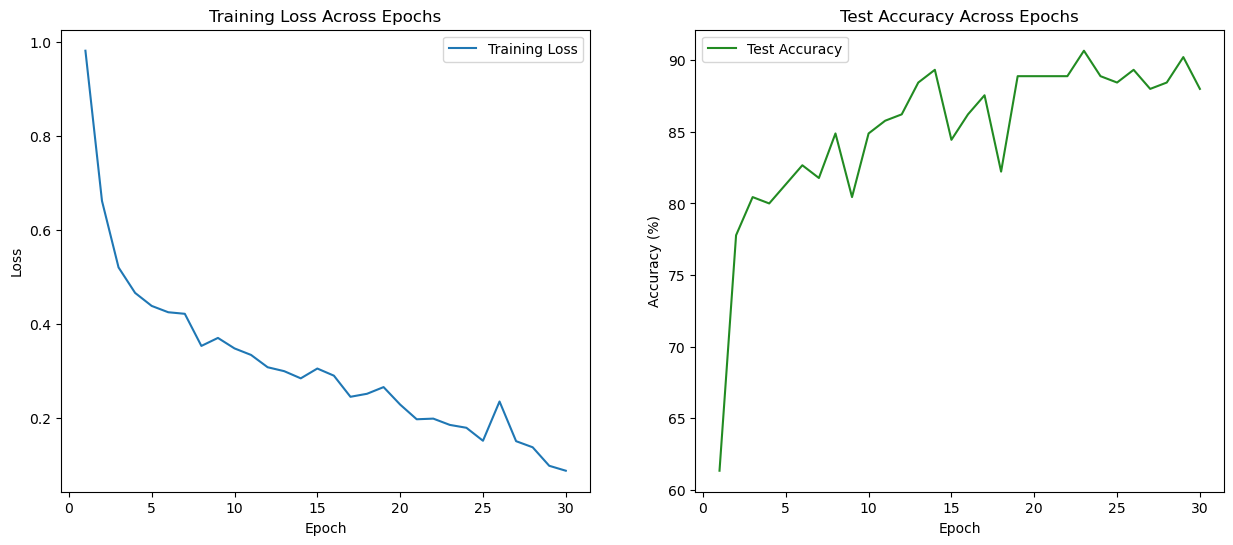

In [116]:
train_losses = []
test_accuracies = []

for epoch in range(30):
    print(f'Training epoch {epoch}...')
    running_loss = 0.0
    net.train()  # Ensure training mode is active

    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad()  # Clear accumulated gradients
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        running_loss += loss.item()
        
    train_losses.append(running_loss / len(train_loader))
    
    accuracy = calculate_accuracy(net, test_loader)  # Evaluate on test data
    test_accuracies.append(accuracy)
    print(f'Epoch {epoch}: Loss = {train_losses[-1]:.4f}, Accuracy = {accuracy:.2f}%')

plot_performance_and_loss(train_losses, test_accuracies)


In [117]:
# Saving the trained model's state dictionary to a file
torch.save(net.state_dict(), 'trained_net.pth')

# Load the trained model for further evaluation
net = ConvNeuralNet()
net.load_state_dict(torch.load('trained_net.pth'))

/tmp/ipykernel_357962/102250063.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('trained_net.pth'))


<All keys matched successfully>

## Evaluation

In [118]:
correct = 0
total = 0

all_labels = []
all_predictions = []
net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

report = classification_report(all_labels, all_predictions, target_names=dataset.classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.75      0.92      0.83        60
        Rain       0.90      0.60      0.72        43
       Shine       0.90      0.90      0.90        51
     Sunrise       0.99      1.00      0.99        71

    accuracy                           0.88       225
   macro avg       0.88      0.86      0.86       225
weighted avg       0.89      0.88      0.88       225



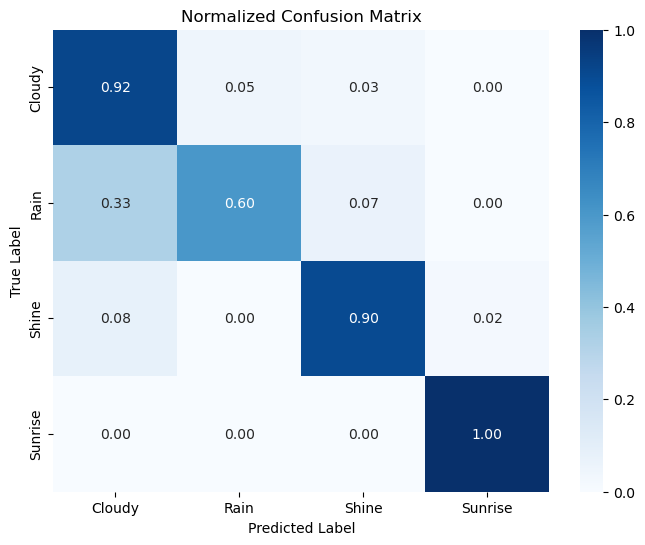

In [119]:
#def visualize_model_performance(report):
# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Normalize confusion matrix for better readability
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


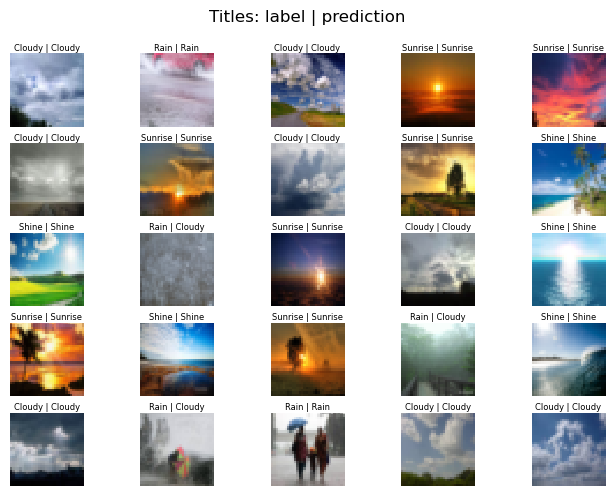

In [120]:
# for better visualization
def denormalize_image(image, mean, std):
    """
    Denormalize an image tensor using the given mean and std.
    Args:
        image (torch.Tensor): The image tensor (C, H, W).
        mean (list): Mean values used for normalization.
        std (list): Standard deviation values used for normalization.
    Returns:
        torch.Tensor: Denormalized image.
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

def plot_predictions(images, labels, predictions, class_names, mean, std, num_images=25):
    """
    Plots a grid of images with true labels and predicted labels.
    
    Args:
        images (torch.Tensor): Tensor of images (batch, channels, height, width).
        labels (list or torch.Tensor): True labels.
        predictions (list or torch.Tensor): Predicted labels.
        class_names (list): List of class names corresponding to label indices.
        mean (list): Mean values used for normalization.
        std (list): Standard deviation values used for normalization.
        num_images (int): Total number of images to plot (default: 25).
    """
    num_images = min(num_images, len(images))  # Limit to available images
    grid_size = int(np.ceil(np.sqrt(num_images)))  # Grid size (e.g., 5x5)

    # Create the plot
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(7, 5))
    
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            # Denormalize the image
            img = denormalize_image(images[i], mean, std)  # Output shape: (3, H, W)
            img = img.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
            img = np.clip(img, 0, 1)  # Ensure pixel values are in the [0, 1] range

            # Display the image
            ax.imshow(img, interpolation='nearest')
            ax.axis('off')

            # Set the title
            true_label = class_names[labels[i]]
            pred_label = class_names[predictions[i]]
            ax.set_title(f"{true_label} | {pred_label}", fontsize=6, pad=2)  # Smaller font, reduced padding
        else:
            ax.axis('off')  # Hide unused subplots
    plt.suptitle("Titles: label | prediction")
    plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
    plt.show()


class_names = dataset.classes
# Get a batch of test data
images, labels = next(iter(test_loader))
# Make predictions
outputs = net(images)
_, predicted = torch.max(outputs, 1)
# Plot the results
plot_predictions(images, labels, predicted, class_names, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])